# Exemplo de previsão de séries temporais com ARIMA

**Resumo:**

* Neste notebook, estudaremos as [ocorrências de acidentes de trânsito em rodovias brasileiras registradas pela Polícia Rodoviária Federal](https://portal.prf.gov.br/dados-abertos-acidentes) para entendermos séries temporais na prática.
 
---

**Autores:**

* [Carlos Maurício Seródio Figueiredo](https://www.linkedin.com/in/cmsfigueiredo/): É professor adjunto da Escola Superior de Tecnologia da Universidade do Estado do Amazonas (EST/UEA) e professor colaborador do Programa de Pós-graduação em Informática da Universidade Federal do Amazonas. Também é co-fundador do Laboratório de Sistemas Inteligentes da UEA e pesquisador no Samsung Ocean Manaus.
* [Alice Adativa Ferreira Menezes](https://www.linkedin.com/in/alice-adativa/): É doutoranda na Universidade Federal do Amazonas (UFAM) e  pesquisadora no Samsung Ocean Manaus.

---

**Para saber mais:**

* Palestras e cursos do [Samsung Ocean](http://www.oceanbrasil.com/).
* Robert H. Shumway. Time series analysis and its applications. Springer, 2000.
* Aileen Nielsen. Practical Time Series Analysis. O’Reilly, 2019.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [ ]:
sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif',
               'fontname': 'Times New Roman'})

## 1) Carregando e tratando os dados

* A base de dados para o nosso estudo foi obtida por meio da iniciativa de dados abertos da [Polícia Rodoviária Federal](https://portal.prf.gov.br/dados-abertos-acidentes). 


* Você tem a opção de baixar estes dados na fonte e fazer o upload no Kaggle, porém já temos essa [base de dados disponível publicamente](https://www.kaggle.com/mcamera/brazil-highway-traffic-accidents) nesta plataforma.


* Nas as próximas seções, utilizaremos dados dos anos de 2017, 2018 e 2019 para o nosso estudo.

In [ ]:
datatran_2017_df = pd.read_csv('../input/brazil-highway-traffic-accidents/por_ocorrencias/datatran2017.csv', 
                               sep = ';',
                               encoding = 'latin-1')

datatran_2018_df = pd.read_csv('../input/brazil-highway-traffic-accidents/por_ocorrencias/datatran2018.csv', 
                               sep = ';',
                               encoding = 'latin-1')

datatran_2019_df = pd.read_csv('../input/brazil-highway-traffic-accidents/por_ocorrencias/datatran2019.csv', 
                               sep = ';',
                               encoding = 'latin-1')

In [ ]:
datatran_2017_df.head()

In [ ]:
datatran_2018_df.head()

In [ ]:
datatran_2019_df.head()

In [ ]:
datatran_df = pd.concat([datatran_2017_df, datatran_2018_df, datatran_2019_df])

In [ ]:
datatran_df

---
* Antes de trabalhar com séries temporais, no geral, você precisa converter e transformar os dados caso seja necessário. 


* Normalmente estes dados estão em diferentes formatos dentro de um DataFrame.


* Neste exemplo, vamos analisar especificamente informações a respeito da **data em que o acidente ocorreu**.
---

In [ ]:
datatran_df.dtypes

In [ ]:
datatran_df['data_inversa'] = pd.to_datetime(datatran_df['data_inversa'], 
                                             yearfirst = True,
                                             format = '%Y-%m-%d')

In [ ]:
datatran_df.sort_values(by = 'data_inversa', inplace = True)

In [ ]:
datatran_df

In [ ]:
datatran_df.dtypes

## 2) Criando a série temporal


* Para a criação de uma série temporal, você pode, por exemplo, agrupar as ocorrências do seu objeto de estudo de acordo com algum parâmetro.


* Neste estudo, iremos agrupar a ocorrência de acidentes de trânsito por dia, mas nada impede que os dados sejam agrupados por meses, anos, trimestres, semestres, etc. 


* Vale lembrar que quanto maior a granularidade dos seus dados, maior é a chance da realização de uma previsão bem sucedida.

In [ ]:
datatran_st = datatran_df['data_inversa'].groupby(datatran_df['data_inversa'].dt.to_period('D')).agg('count').to_frame()

---
* Exemplo de como os dados podem ser agrupados por meses:
    ~~~python
    datatran_st = datatran_df['data_inversa'].groupby(datatran_df['data_inversa'].dt.to_period('M')).agg('count').to_frame()
    ~~~


* Exemplo de como os dados podem ser agrupados por anos:
    ~~~python
    datatran_st = datatran_df['data_inversa'].groupby(datatran_df['data_inversa'].dt.to_period('Y')).agg('count').to_frame()
    ~~~
---

In [ ]:
datatran_st.head()

In [ ]:
datatran_st.columns = ['acidentes']

In [ ]:
datatran_st

## 3) Visualizando a série temporal

In [ ]:
datatran_st_plot = datatran_st.plot(figsize=(12,5))

datatran_st_plot.set_xlabel('Data da ocorrência',
                            fontsize=15,
                            weight='bold')

datatran_st_plot.set_ylabel('Qtd. de ocorrências',
                            fontsize=15,
                            weight='bold')

datatran_st_plot.legend().remove()

figure = datatran_st_plot.get_figure()
figure.show()

## 4) Decompondo a série temporal

In [ ]:
decomposicao_st = seasonal_decompose(datatran_st,
                                     period = 30)

In [ ]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(12,8))

decomposicao_st.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observada')

decomposicao_st.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendência')

decomposicao_st.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Sazonalidade')

decomposicao_st.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Ruído')

axes[3].set_xlabel('Data da ocorrência',
                    fontsize=15,
                    weight='bold')

fig.show()

## 5) Treinando o modelo ARIMA

### 5.1) Separando amostras de treino e de teste


* Antes de treinarmos o nosso modelo, precisamos separar as amostras de treino e teste.


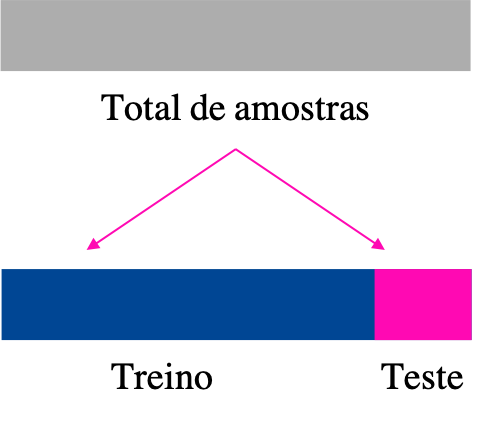

* Desta forma, para o treino o modelo terá acesso à "resposta correta" para ajustar seus parâmetros.


* A partir daí, o modelo fará previsões que serão comparadas às amostras de teste.


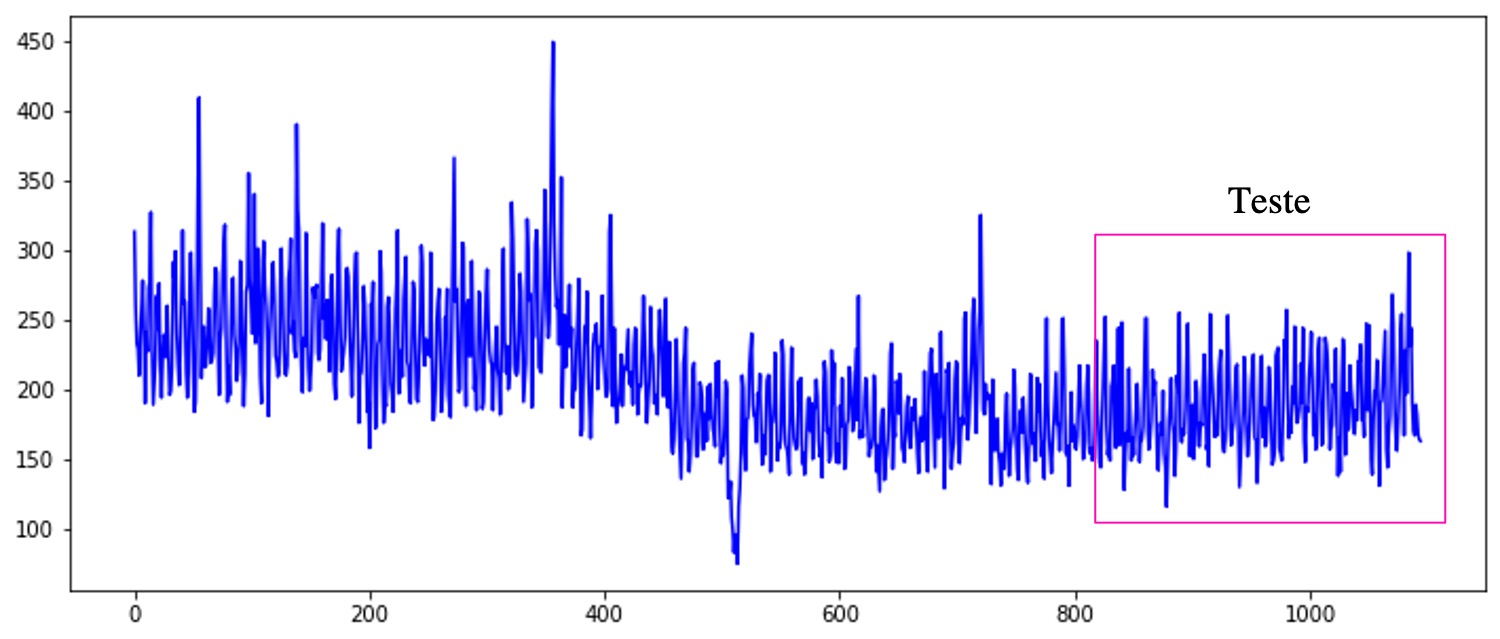

In [ ]:
X = datatran_st.values

In [ ]:
len(X)

---
* Por questões de tempo, iremos separar 90% das amostras para treino e 10% para teste, porém outras proporções de separações de amostras são mais apropriadas.
---

In [ ]:
tam = int(len(X) * 0.90)
treino, teste = X[0:tam], X[tam:len(X)]

In [ ]:
print('treino = {}, teste = {}'.format(len(treino), len(teste)))

### 5.2) Encontrando os melhores valores para p, d, e q 


* p --> valor atual depende dos p valores anteriores;


* d --> grau da tendência (linear, quadrática etc.);


* q --> quantidade de observações passadas que a série de relaciona bem.

In [ ]:
p = d = q = range(0,5)

In [ ]:
print('p = {}\nd = {}\nq = {}'.format(p, d, q))

In [ ]:
combinacoes_pdq = list(itertools.product(p,d,q))

In [ ]:
combinacoes_pdq

In [ ]:
len(combinacoes_pdq)

In [ ]:
%%time

menor_aic = -1
melhor_pdq = (0, 0, 0)

for pdq in combinacoes_pdq:
    try:
        model_arima = ARIMA(treino, order = pdq)
        model_arima_fit = model_arima.fit()
        
        print(pdq, model_arima_fit.aic)
        
        if menor_aic == -1:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
        elif model_arima_fit.aic < menor_aic:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
    except:
        continue

In [ ]:
print('menor_aic = {}, melhor_pdq = {}'.format(menor_aic, melhor_pdq))

### 5.3) Treinando o modelo

In [ ]:
lista_historico = list(treino)
lista_previsoes = list()

In [ ]:
%%time

for indice in range(len(teste)):
    modelo = ARIMA(lista_historico, order = melhor_pdq)
    modelo_fit = modelo.fit(disp = 0)
    previsao = modelo_fit.forecast()[0]
    lista_previsoes.append(previsao)
    lista_historico.append(teste[indice])
    
    print('previsto = {}, esperado = {}'.format(previsao, teste[indice]))

### 5.4) Avaliando o modelo

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(teste, label="Série Temporal")
plt.plot(lista_previsoes, color='red', label="Previsão")
plt.legend()
plt.show()

In [ ]:
print('teste = {}, previsão = {}'.format(len(teste), len(lista_previsoes)))

---
* Para avaliar o modelo, iremos utilizar o Erro Quadrático Médio (Mean Squared Error ou MSE).


$MSE = \frac{1}{n}\sum_{i = 1}^{n}(teste_{i} - previsao_{i})^2$


* Exemplo 1: resultado com estimativas semelhantes.


$n = 3$


$teste = \left [100, 102, 104\right ]$


$previsao = \left [102, 104, 106\right ]$


$MSE = \frac{(100 - 102)^2 + (102 - 104)^2 + (104 - 106)^2}{3} = \frac{4 + 4 + 4}{3} = 4$


* Exemplo 2: resultado com estimativas pouco semelhantes.


$n = 3$


$teste = \left [100, 102, 104\right ]$


$previsao = \left [200, 202, 204\right ]$


$MSE = \frac{(100 - 200)^2 + (102 - 202)^2 + (104 - 204)^2}{3} = \frac{10000 + 10000 + 10000}{3} = 10000$


* Quanto mais próximo de 0 o MSE estiver, melhor.
---

In [ ]:
error = mean_squared_error(teste, lista_previsoes)
print('Test MSE: %.4f' % error)

### Quais seriam outras análises que poderíamos fazer com estes dados?

## 6) Trabalhando com dados de 2020

In [ ]:
datatran_2020_df = pd.read_csv('../input/brazil-highway-traffic-accidents/por_ocorrencias/datatran2020.csv', 
                               sep = ';',
                               encoding = 'latin-1')

In [ ]:
datatran_2020_df.head()

In [ ]:
datatran_new_df = pd.concat([datatran_2017_df, datatran_2018_df, datatran_2019_df, datatran_2020_df])

In [ ]:
datatran_new_df.head()

In [ ]:
datatran_new_df.dtypes

In [ ]:
datatran_new_df['data_inversa'] = pd.to_datetime(datatran_new_df['data_inversa'], 
                                                 yearfirst = True,
                                                 format = '%Y-%m-%d')

In [ ]:
datatran_new_df.sort_values(by = 'data_inversa', inplace = True)

In [ ]:
datatran_new_df

In [ ]:
datatran_new_df.dtypes

In [ ]:
datatran_new_st = datatran_new_df['data_inversa'].groupby(datatran_new_df['data_inversa'].dt.to_period('D')).agg('count').to_frame()

In [ ]:
datatran_new_st.columns = ['acidentes']

In [ ]:
datatran_new_st

In [ ]:
datatran_new_st_plot = datatran_new_st.plot(figsize=(12,5))

datatran_new_st_plot.set_xlabel('Data da ocorrência',
                                fontsize=15,
                                weight='bold')

datatran_new_st_plot.set_ylabel('Qtd. de ocorrências',
                                fontsize=15,
                                weight='bold')

datatran_new_st_plot.legend().remove()

figure = datatran_new_st_plot.get_figure()
figure.show()

In [ ]:
decomposicao_new_st = seasonal_decompose(datatran_new_st,
                                         period = 30)

In [ ]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(12,8))

decomposicao_new_st.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observada')

decomposicao_new_st.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendência')

decomposicao_new_st.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Sazonalidade')

decomposicao_new_st.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Ruído')

axes[3].set_xlabel('Data da ocorrência',
                    fontsize=15,
                    weight='bold')

fig.show()

In [ ]:
X = datatran_new_st.values
tam = int(len(X) * 0.90)
treino, teste = X[0:tam], X[tam:len(X)]

print('treino = {}, teste = {}'.format(len(treino), len(teste)))

In [ ]:
%%time

p = d = q = range(0,5)
combinacoes_pdq = list(itertools.product(p,d,q))

menor_aic = -1
melhor_pdq = (0, 0, 0)

for pdq in combinacoes_pdq:
    try:
        model_arima = ARIMA(treino, order = pdq)
        model_arima_fit = model_arima.fit()
        
        print(pdq, model_arima_fit.aic)
        
        if menor_aic == -1:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
        elif model_arima_fit.aic < menor_aic:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
    except:
        continue

In [ ]:
print('menor_aic = {}, melhor_pdq = {}'.format(menor_aic, melhor_pdq))

In [ ]:
%%time

lista_historico = list(treino)
lista_previsoes = list()

for indice in range(len(teste)):
    modelo = ARIMA(lista_historico, order = melhor_pdq)
    modelo_fit = modelo.fit(disp = 0)
    previsao = modelo_fit.forecast()[0]
    lista_previsoes.append(previsao)
    lista_historico.append(teste[indice])
    
    print('previsto = {}, esperado = {}'.format(previsao, teste[indice]))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(teste, label="Série Temporal")
plt.plot(lista_previsoes, color='red', label="Previsão")
plt.legend()
plt.show()

In [ ]:
print('teste = {}, previsão = {}'.format(len(teste), len(lista_previsoes)))

In [ ]:
error = mean_squared_error(teste, lista_previsoes)
print('Test MSE: %.3f' % error)